In [21]:
import os,sys,string, time
import ROOT
from math import *
from ROOT import gPad, TTree, TObject, TFile, gDirectory, TH1D, TH2D, TH3D, TCanvas, gROOT, TGaxis, gStyle, TColor, TLegend, THStack, TChain, TLatex, TText, TCollection, kRed, kBlue
from array import array
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from root_pandas import read_root
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
from importlib import reload
import awkward as awk

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
import Utilities.Variables_bins as Variables_bins
import Utilities.Functions as Functions
import Utilities.Sys_unc_variables as Sys_unc
from Utilities.ipython_exit import exit

np.seterr(divide='ignore', invalid='ignore')

print ('Success')

Success


# Reading in .pkl files

In [2]:
Params = {"Run":"run3", #The run number, so far either "run1" or "run3"
          "Load_single_file":False, #This will override everything else, put the desired file in the "single_file" line
          "single_file":"overlay",
          "Load_standard_bkgs":True,
          "Load_DetVars":False,
          "Only_keep_common_DetVar_evs":True,
          "Load_Signal_DetVars":False,
          "Load_data":True,
          "FLATTEN":False, #Have one row per reconstructed object in the analysis dataframe
          "only_presel":True, #Create small files containing only variables necessary for pre-selection, for making pre-selection plots
          "Load_truth_vars":False,
          "Load_lepton_signal":True,
          'Load_pi0_signal_DetVars':False,
          "Load_pi0_signal":False}

Params, samples = Functions.create_sample_list(Params)
loc_pkls = "pkl_files/"+Params["Run"]+"/current_files/"+Params["variables_string"]+"/"

Loading these run3 samples: 
['signal', 'overlay', 'dirtoverlay', 'beamoff', 'beamgood']


In [3]:
samples_dict = {}

for sample in samples:
    if sample in Constants.Detector_variations:
        file = pd.read_pickle(loc_pkls+"DetVars/overlay_"+Params["Run"]+"_"+Params["variables_string"]+f"_{sample}_"+
                              Params["Flat_state"]+"_"+Params["Reduced_state"]+"_FINAL.pkl")
        samples_dict[sample] = file
    elif Params["Load_Signal_DetVars"] == True:
        file = pd.read_pickle(loc_pkls+"Signal_DetVars/"+Params["Run"]+f"_{sample}_"+Params["Reduced_state"]+"_FINAL.pkl")
        samples_dict[sample] = file
    else:
        if sample == 'signal':
            for HNL_mass in Constants.HNL_mass_samples:
                # file = pd.read_pickle(loc_pkls+f"signal_{HNL_mass}MeV_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_final_gen.pkl")
                file = pd.read_pickle(loc_pkls+f"signal_{HNL_mass}MeV_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_FINAL.pkl")
                samples_dict[HNL_mass] = file
        elif sample == 'pi0_signal':
            for HNL_mass in Constants.HNL_mass_pi0_samples:
                # file = pd.read_pickle(loc_pkls+f"{sample}_{HNL_mass}MeV_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_final_gen.pkl")
                # file = pd.read_pickle(loc_pkls+f"{sample}_{HNL_mass}MeV_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_ultimate.pkl")
                file = pd.read_pickle(loc_pkls+f"{sample}_{HNL_mass}MeV_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_FINAL.pkl")
                samples_dict[str(HNL_mass)+"_pi0"] = file
        elif (Params["Load_single_file"] == True) and (isinstance(sample,int)):
            HNL_mass = sample
            # file = pd.read_pickle(loc_pkls+f"signal_{HNL_mass}MeV_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_final_gen.pkl")
            file = pd.read_pickle(loc_pkls+f"signal_{HNL_mass}MeV_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_FINAL.pkl")
            samples_dict[HNL_mass] = file
        else: 
            # file = pd.read_pickle(loc_pkls+f"{sample}_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_final_gen.pkl")
            file = pd.read_pickle(loc_pkls+f"{sample}_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_FINAL.pkl")
            samples_dict[sample] = file

print(samples_dict.keys())

dict_keys([2, 10, 20, 50, 100, 150, 'overlay', 'dirtoverlay', 'beamoff', 'beamgood'])


In [4]:
for sample in samples_dict:
    print(f"{sample} length is " + str(len(samples_dict[sample])))
print("Loading these variables:")
print(samples_dict[sample].keys())

2 length is 45159
10 length is 44463
20 length is 46022
50 length is 44579
100 length is 45304
150 length is 44031
overlay length is 748702
dirtoverlay length is 389264
beamoff length is 3211097
beamgood length is 1104349
Loading these variables:
Index(['nslice', 'flash_time', 'nu_flashmatch_score', 'NeutrinoEnergy2',
       'contained_fraction', 'trk_score', 'trk_score_v', 'n_pfps',
       'swtrig_pre', 'swtrig_post', 'crtveto', 'run', 'sub', 'evt'],
      dtype='object')


In [5]:
print(samples_dict['overlay'].keys())

Index(['nslice', 'flash_time', 'nu_flashmatch_score', 'NeutrinoEnergy2',
       'contained_fraction', 'trk_score', 'trk_score_v', 'n_pfps',
       'swtrig_pre', 'swtrig_post', 'crtveto', 'weightSplineTimesTune',
       'ppfx_cv', 'npi0', 'run', 'sub', 'evt', 'weight'],
      dtype='object')


## Applying Software Trigger

In [6]:
def Apply_swtrig(df):
    query="swtrig_pre>0"
    df.query(query)

def Apply_flash_shift(df, sample_type):
    #Only required for beam off, overlay, dirtoverlay and signal (i.e all except beamon data)
    if(sample_type=="beamoff"): df["flash_time"]=df["flash_time"] -0.359
    else: df["flash_time"]=df["flash_time"] - 0.304

In [7]:
# swtrig_dict = {}
Pre_swtrig_dict = {}
swtrig = {}
apply_swtrig = False
if(apply_swtrig): print("Applying software trigger!")
for sample in samples_dict:
    Pre_swtrig_dict[sample] = len(samples_dict[sample]) #Should weight this properly, i.e take sum of weights for the total number.
    if(apply_swtrig):
        # Apply_swtrig(samples_dict[sample])
        if Params["Run"]=="run1":
            swtrig[sample] = samples_dict[sample].query("swtrig_pre>0").copy()
        if Params["Run"]=="run3":
            swtrig[sample] = samples_dict[sample].query("swtrig_post==1").copy() #Took this from Owen's code, should check exactly what it's doing
    else: swtrig[sample] = samples_dict[sample].copy()
    if sample != "beamgood":
        Apply_flash_shift(swtrig[sample], sample)

In [8]:
for sample in samples_dict:
    swtrig_effic = 100*(len(swtrig[sample])/Pre_swtrig_dict[sample])
    print(f"{sample} efficiency is " + str(swtrig_effic) + "%")

2 efficiency is 100.0%
10 efficiency is 100.0%
20 efficiency is 100.0%
50 efficiency is 100.0%
100 efficiency is 100.0%
150 efficiency is 100.0%
overlay efficiency is 100.0%
dirtoverlay efficiency is 100.0%
beamoff efficiency is 100.0%
beamgood efficiency is 100.0%


In [9]:
print(swtrig.keys())

dict_keys([2, 10, 20, 50, 100, 150, 'overlay', 'dirtoverlay', 'beamoff', 'beamgood'])


# Plotting variables before preselection

In [10]:
#Want to have arrows drawn on for where the preselection cut goes
HNL_mass = 100
if Params["Load_pi0_signal"]:
    HNL_mass = f"{HNL_mass}_pi0" #only plotting one at a time
variable = 'flash_time'

samples_plotting = {"overlay":swtrig["overlay"],
                    "dirtoverlay":swtrig["dirtoverlay"],
                    "beamoff":swtrig["beamoff"],
                    "signal":swtrig[HNL_mass]}

if Params["Run"] == "run1":
    sample_norms = {"overlay":Constants.run1_POT_scaling_dict["overlay"], #WAS using SF_overlay_run1
                    "dirtoverlay":Constants.run1_POT_scaling_dict["dirtoverlay"],
                    "beamoff":Constants.run1_POT_scaling_dict["beamoff"],
                    "signal":Constants.run1_POT_scaling_dict[HNL_mass]}
    flat_sys_vars_dict = Sys_unc.run1_Sys_unc
elif Params["Run"] == "run3":
    sample_norms = {"overlay":Constants.run3_POT_scaling_dict["overlay"],
                    "dirtoverlay":Constants.run3_POT_scaling_dict["dirtoverlay"],
                    "beamoff":Constants.run3_POT_scaling_dict["beamoff"],
                    "signal":Constants.run3_POT_scaling_dict[HNL_mass]}
    flat_sys_vars_dict = Sys_unc.run3_Sys_unc

if Params["Load_data"] == True:
    data_dict = {"beamgood":samples_dict["beamgood"]}
    data_norm = {"beamgood":1.0} #No scaling as this is data, should have scaled MC to this POT.
    samples_plotting.update(data_dict)
    sample_norms.update(data_norm)
    
PT.HNL_scaling_calculator(samples_plotting,sample_norms)


The ratio of overlay to HNL events is 228490150

The ratio of all bkgs to HNL events is 1588582728



In [11]:
for sample in samples_plotting:
    print(sample)
    
print(Constants.Preselection_dict_for_plot)

overlay
dirtoverlay
beamoff
signal
beamgood
{'nslice': 'nslice==1', 'flash_time': 'flash_time > 6.55 and flash_time < 16.5', 'nu_flashmatch_score': 'nu_flashmatch_score < 15', 'NeutrinoEnergy2': 'NeutrinoEnergy2 < 500', 'contained_fraction': 'contained_fraction > 0.9', 'trk_score': 'trk_score < 0.97', 'n_pfps': 'n_pfps < 6'}


## Plot data and MC

In [ ]:
# runsplit=16880
# if(run=="Run1"):
#     print("nope")
# else:
#     sample_info["beamgood"]["POT_post"]=9.049e+19
#     sample_info["beamgood"]["POT_pre"]=4.105e+20
#     sample_info["beamgood"]["hwtrigs_post"]=1845342
#     sample_info["beamgood"]["hwtrigs_pre"]=8519685
#     sample_info["beamoff"]["hwtrigs_post"]=14382545.975000
#     sample_info["beamoff"]["hwtrigs_pre"]= 18772346.425000
    
    # i split the MC at 16880 but this is actually somewhat arbitary (the run is just defined by the underlying unbiased event)
    # doesnt actually create a very approprieate split. #can also not split MC and just scale all together with updated threshold. (this actually gives best agreement)
    #i dont think suprising because we know simualtion vs data light yeild not great especially at low light level.

In [72]:
def Plot_preselection_variable_data(variable, samples=[], sample_norms=[], sample_weights_full=[], query="nslice>-1", xlabel=[],xlims=[0,0],bins=40,figsize=[10,10],
                                    dpi=100,MergeBins=False, discrete=False, HNL_mass = 0, HNLplotscale=100000,density=False,legloc="best",logy = False,
                                    cutline = 0.0, show_ev_nums=False, CalcSys=False, xticks=[], colours_sample={}, order=[], sys_dict={}, centre_bins=False,
                                    hatch=False, ylabel="Events", Frame=True, arrow_place=[], ylimit=None, legsize=22, display=True, savefig=False,
                                    savename="test", HNL_scale_label=False, title_name = ""):
    
    if(samples==[]): raise Exception("Specify samples dict") 
    if(xlabel==[]): xlabel=variable
    if(colours_sample=={}): colours_sample = {'overlay':Constants.sample_colours['overlay'],
                                              'dirtoverlay':Constants.sample_colours['dirtoverlay'],
                                              'beamoff':Constants.sample_colours['beamoff'],
                                              'signal':Constants.sample_colours['signal']}
    if(order==[]): order = ["beamoff","overlay","dirtoverlay"] #From bottom to top in stack
    if(sys_dict=={} and CalcSys==True): raise Exception("Specify systematic errors dict")
    
    beamgood=samples["beamgood"].query(query) #I should loop through samples instead, so don't always need data
    beamoff=samples["beamoff"].query(query)
    overlay=samples["overlay"].query(query)
    dirtoverlay=samples["dirtoverlay"].query(query)
    signal=samples["signal"].query(query)
    
    var_Data=beamgood[variable]
    var_Offbeam=beamoff[variable]
    var_Overlay=overlay[variable]
    var_Dirt=dirtoverlay[variable]
    var_HNL=signal[variable]
    
    variable_sample = {'overlay':var_Overlay,
                       'dirtoverlay':var_Dirt,
                       'beamoff':var_Offbeam,
                       'signal':var_HNL}
    
    weight_Offbeam=np.ones(len(var_Offbeam))*sample_norms["beamoff"]
    weight_Overlay=overlay["weight"]*sample_norms["overlay"]
    weight_Dirt=dirtoverlay["weight"]*sample_norms["dirtoverlay"]
    weight_signal=np.ones(len(var_HNL))*sample_norms["signal"]*HNLplotscale
    
    if sample_weights_full == []:
        weights_sample = {'overlay':weight_Overlay,
                          'dirtoverlay':weight_Dirt,
                          'beamoff':weight_Offbeam,
                          'signal':weight_signal}
    else: weights_sample=sample_weights_full
    
    if xlims[0] == 0 and xlims[1] == 0: xlims = [min(var_Overlay),max(var_Overlay)]
    
    if(isinstance(bins, int)):
        nbins=bins
        if centre_bins == True:
            bins=np.linspace(xlims[0],xlims[1],nbins+1)-0.5
        else:
            bins=np.linspace(xlims[0],xlims[1],nbins+1)
    else: nbins=len(bins)-1
    
    #all UNWEIGHTED hists
    totbkg=np.histogram(var_Offbeam,bins=bins,range=xlims)[0]+np.histogram(var_Dirt,bins=bins,range=xlims)[0]+np.histogram(var_Overlay,bins=bins,range=xlims)[0]
    offbkg=np.histogram(var_Offbeam,bins=bins,range=xlims)[0]
    overlaybkg=np.histogram(var_Overlay,bins=bins,range=xlims)[0]
    dirtbkg=np.histogram(var_Dirt,bins=bins,range=xlims)[0]
    
    #weighted hists
    offbkg_weighted=np.histogram(var_Offbeam,bins=bins,range=xlims,weights=weight_Offbeam)[0]
    overlaybkg_weighted=np.histogram(var_Overlay,bins=bins,range=xlims,weights=weight_Overlay)[0]
    dirtbkg_weighted=np.histogram(var_Dirt,bins=bins,range=xlims,weights=weight_Dirt)[0]
           
    #Testing Owens way, Err = sqrt(N*S.F**2)
    mc_w=np.histogram(var_Overlay,bins=bins,range=xlims,weights=weight_Overlay**2)
    off_w=np.histogram(var_Offbeam,bins=bins,range=xlims,weights=weight_Offbeam**2)
    dirt_w=np.histogram(var_Dirt,bins=bins,range=xlims,weights=weight_Dirt**2)
    
    off_err=np.sqrt(off_w[0])
    mc_err=np.sqrt(mc_w[0])
    dirt_err=np.sqrt(dirt_w[0])
    
    # stat_bkgerr=np.sqrt(offbkg_stat**2+overlaybkg_stat**2+dirtbkg_stat**2) #Adding stat errors in quadrature, my way
    stat_bkgerr=np.sqrt(off_err**2+mc_err**2+dirt_err**2) #Adding stat errors in quadrature
    tot_mcerr = stat_bkgerr
    
    if(CalcSys): #Owen's way of calculating systematics for arbitrary variable, using my new function
        frac_total = 0
        for frac_sys in sys_dict[variable]:
            frac_total += frac_sys**2 #Adding systematic sources of bkg in quadrature
        
        total_frac_sys = np.sqrt(frac_total)
        total_sys_err = frac_total*overlaybkg_weighted
        
        dirt_norm_err_fac = 1.0
        dirt_norm_err=dirtbkg_weighted*dirt_norm_err_fac
        tot_mcerr=np.sqrt( stat_bkgerr**2+total_sys_err**2+dirt_norm_err**2)
    
    if(MergeBins): #remove bins with zero bkg prediction
        bins_new=[]
        for i,bin_bkg in enumerate(totbkg):
            if(offbkg[i]>1 or overlaybkg[i]>1):
                bins_new.append(bins[i])
                
        bins_new.append(bins[-1])

        bins=bins_new
    
    # fig,ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=figsize,dpi=dpi) #Just variable plot
    fig,ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=figsize,dpi=dpi)
    
    plt.sca(ax[0])
        
    if(discrete):
        bins = np.arange(xlims[0], xlims[1] + 1.5) - 0.5
        xlims[0]=xlims[0]-1
        xlims[1]=xlims[1]+1
        ax[0].set_xticks(bins + 0.5)
        nbins=len(bins)-1
        
    x,y=np.histogram(var_Data,bins=bins,range=xlims,density=density)
    x1,y=np.histogram(var_Data,bins=bins,range=xlims)
    bin_center = [(y[i] + y[i+1])/2. for i in range(len(y)-1)]
    dat_val=x
    # dat_err=np.sqrt(x1)*Functions.safe_div(x,x1) #need to write one for arrays instead of single values.
    dat_err=np.sqrt(x1)*np.nan_to_num(x/x1)

    Datanum=dat_val.sum()
    Offbeamnum=sum(weight_Offbeam)
    Dirtnum=sum(weight_Dirt)
    Overlaynum=sum(weight_Overlay) 
    HNL_num=sum(weight_signal)
    
    if HNL_scale_label==False: HNL_label = f"{HNL_mass} MeV HNL"
    if HNL_scale_label==True: 
        theta = 1e-4
        theta_2 = theta**2
        new_theta_2 = np.sqrt(HNLplotscale)*theta_2
        theta_2_label = sci_notation(new_theta_2, decimal_digits=0)
        HNL_label = f"{HNL_mass} MeV HNL \n" + r"$|U_{\mu4}|^2$ = " + theta_2_label
    
    if show_ev_nums==True:
        labels_sample = {'overlay':fr"In-Cryo $\nu$ ({Overlaynum:.1f})",
                         'dirtoverlay':fr"Out-Cryo $\nu$ ({Dirtnum:.1f})",
                         'beamoff':f"Beam-Off ({Offbeamnum:.1f})",
                         'signal':f"{HNL_mass} MeV HNL ({HNL_num:.1f})"}
        # labels=[fr"In-Cryo $\nu$ ({Overlaynum:.1f})",fr"Out-Cryo $\nu$ ({Dirtnum:.1f})",f"Beam-Off ({Offbeamnum:.1f})"]
        sig_label = [f"{HNL_mass} MeV HNL ({HNL_num:.1f})"]
        data_label = f"NuMI Data ({Datanum:.0f})"
    else:
        labels_sample = {'overlay':fr"In-Cryo $\nu$",
                         'dirtoverlay':fr"Out-Cryo $\nu$",
                         'beamoff':f"Beam-Off",
                         'signal':HNL_label}
                         #'signal':f"{HNL_mass} MeV HNL"}
        # labels=[fr"In-Cryo $\nu$",fr"Out-Cryo $\nu$",f"Beam-Off"]
        sig_label = [HNL_label]
        data_label = "NuMI Data"
    
    plt.errorbar(bin_center,dat_val,yerr=dat_err,fmt='.',color='black',lw=5,capsize=5,elinewidth=3,label=data_label) #Plotting data

    varis, weights, colors, labels = [], [], [], []
    for sample in order:
        varis.append(variable_sample[sample])
        weights.append(weights_sample[sample])
        colors.append(colours_sample[sample])
        labels.append(labels_sample[sample])
            
    plot=plt.hist(varis,
              label=labels,
              range=xlims,bins=bins,
              histtype="stepfilled",
              stacked=True,density=density,linewidth=2,edgecolor="black",
              weights=weights, color=colors)
    
    upvals=np.append((plot[0][2]+tot_mcerr),(plot[0][2]+tot_mcerr)[-1])
    lowvals=np.append((plot[0][2]-tot_mcerr),(plot[0][2]-tot_mcerr)[-1])
    
    if hatch == False:
        plt.fill_between(y, lowvals, upvals,step="post",color="grey",alpha=0.3,zorder=2)
    if hatch == True:
        plt.fill_between(y, lowvals, upvals,step="post",hatch='//',alpha=0,zorder=2)

    color=colours_sample["signal"]
    
    bkg_stack=varis
    bkg_stack_w=weights
    plt.hist(var_HNL,
              label=sig_label,
              range=xlims,bins=bins,
              stacked=True,density=density,
              weights= weight_signal,histtype="step",color=color,lw=4)
    
    if cutline != 0.0:
        plt.axvline(x=cutline, lw=3, color='green', linestyle = 'dashed')
    if arrow_place != []: #No idea how to fix this.
        plt.arrow(arrow_place[0], arrow_place[1], arrow_place[2], arrow_place[3], color='green', shape='full',fill=False, 
                  length_includes_head=True, overhang=0.0, head_width=-0.1, head_length=0.15, lw=3)
    
    if(logy == True):
        plt.yscale("log")
    else:
        plt.yscale("linear")
        
        
    plt.ylabel(ylabel)
    plt.legend(loc=legloc,frameon=Frame, prop={'size': legsize})
    
    # plt.xlabel(xlabel)
    plt.xlim(xlims)
    if ylimit != None: plt.ylim(0,ylimit)
    
    if title_name != "":
        plt.title(title_name)
    
    #---Sub-plot----#
    plt.sca(ax[1])
    
    fracer_data=np.nan_to_num(np.sqrt(x1)/x1)
    x_err=fracer_data*x
    fracer_mc=np.nan_to_num(tot_mcerr/plot[0][2])
    
    rat_err_data=x_err*(1/plot[0][2])
    
    rat_err_mc=fracer_mc
    rat_err=np.sqrt(rat_err_data**2)

    rat_err_mc=np.nan_to_num(rat_err_mc) #other wise the next doesnt plot pro[erly]

    upvals= np.append(1+(rat_err_mc),1+(rat_err_mc)[-1]) #hate this but need to repeat last value to get bar on last bin to work, saw it here https://matplotlib.org/stable/gallery/lines_bars_and_markers/filled_step.html
    lowvals=np.append(1-(rat_err_mc),1-(rat_err_mc)[-1])


    plt.fill_between(y, lowvals, upvals,step="post",color="grey",alpha=0.3,zorder=2)

    rat=np.nan_to_num(x/plot[0][2])
    rat[x==0]=1 #dont think this is a good way to deal with this

    rat_err=np.nan_to_num(rat*np.sqrt(fracer_mc**2+fracer_data**2))
       
    # plt.errorbar(bin_center,rat,yerr=rat_err,fmt='.',color='black',lw=3,capsize=3,elinewidth=1,label="data") #Had this before, but wrong I think
    plt.errorbar(bin_center,rat,yerr=fracer_data,fmt='.',color='black',lw=3,capsize=3,elinewidth=1,label="data")
    plt.ylabel("Data/MC")
    plt.axhline(1,ls='-',color='black')
    plt.axhline(1.1,ls='--',color='grey')
    plt.axhline(0.9,ls='--',color='grey')
    ylim = max(abs(np.nan_to_num(rat)))*1.1
    plt.ylim(0.7,1.3)
    # plt.ylim(0.9,1.1)
    plt.xlim(xlims)
    if xticks != []:
        plt.xticks(xticks)
    
    plt.xlabel(xlabel)
    
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    
    if savefig==True:
        plt.savefig(savename+".pdf")
        plt.savefig(savename+".png")
    if display == False:
        plt.close()

In [57]:
#Calculate sys
Calculate_sys = True
variable = 'flash_time'

reload(PT)
reload(Functions)
reload(Constants)
reload(Sys_unc)
reload(Variables_bins)

if Params["Run"] == "run1": 
    flat_sys_vars_dict = Sys_unc.run1_Sys_unc
    PLOTSCALE = 240000000
if Params["Run"] == "run3": 
    flat_sys_vars_dict = Sys_unc.run3_Sys_unc
    PLOTSCALE = 240000000
    
no_swtrig = "swtrig_post>-99"
swtrig_new = "swtrig_post>0"
swtrig_old = "swtrig_pre>0"

# query=query+" & "+q_control_region

savefig = False

if isinstance(Constants.variable_names_dict[variable],str):x_string = Constants.variable_names_dict[variable]
else: x_string=variable
BINS = Variables_bins.Presel_bins[variable]
XLIMS = [BINS[0],BINS[-1]]

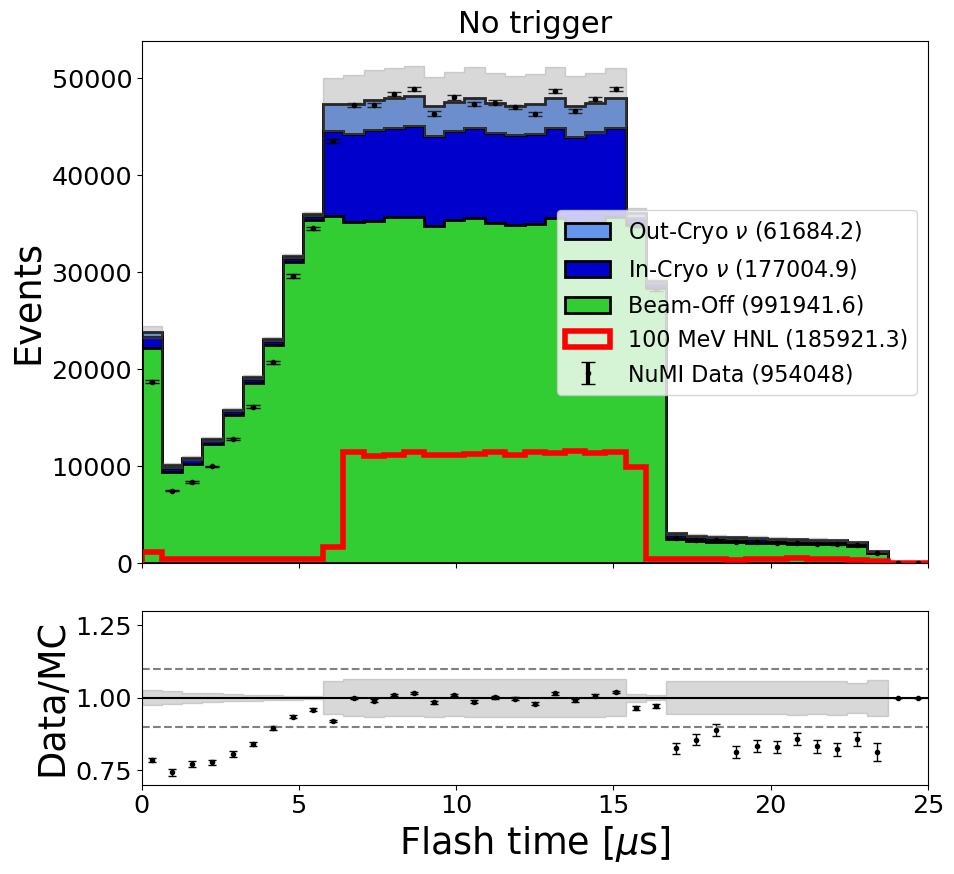

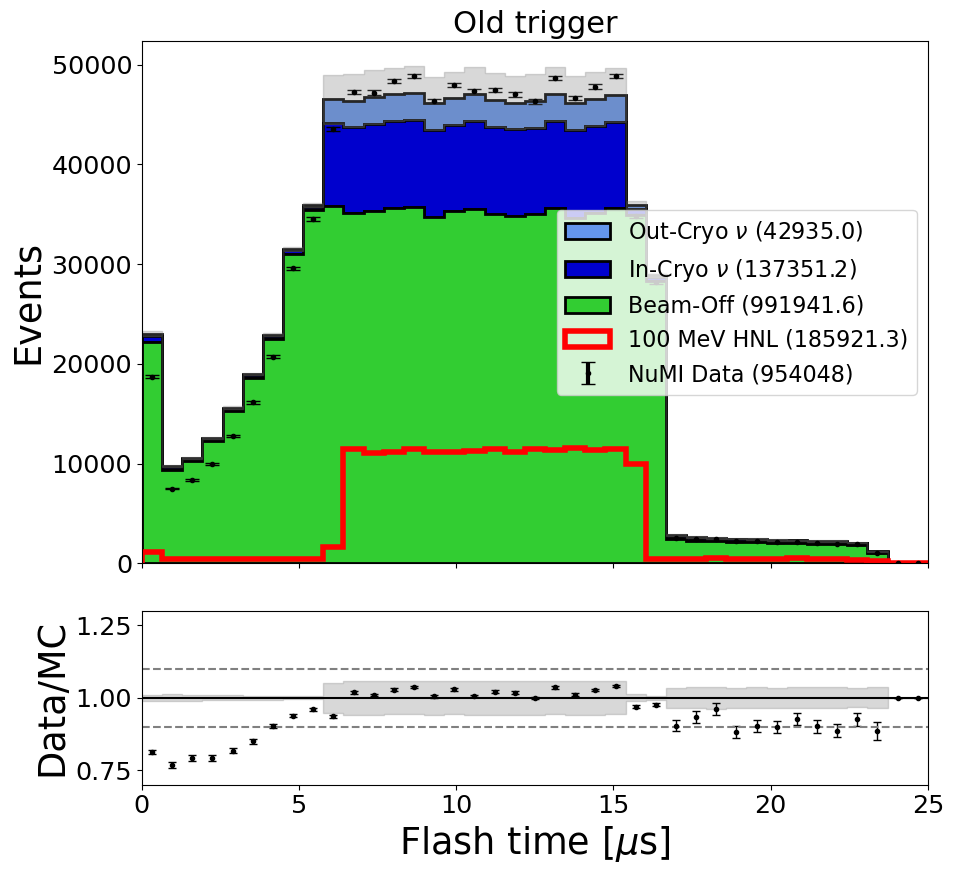

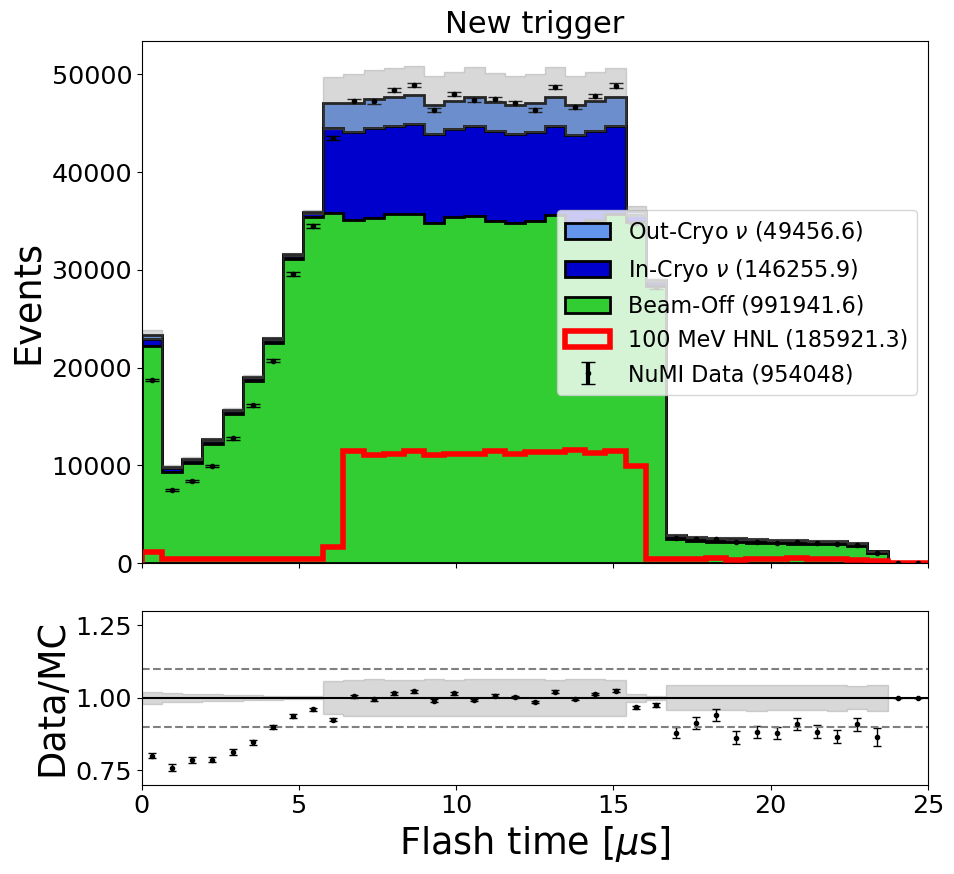

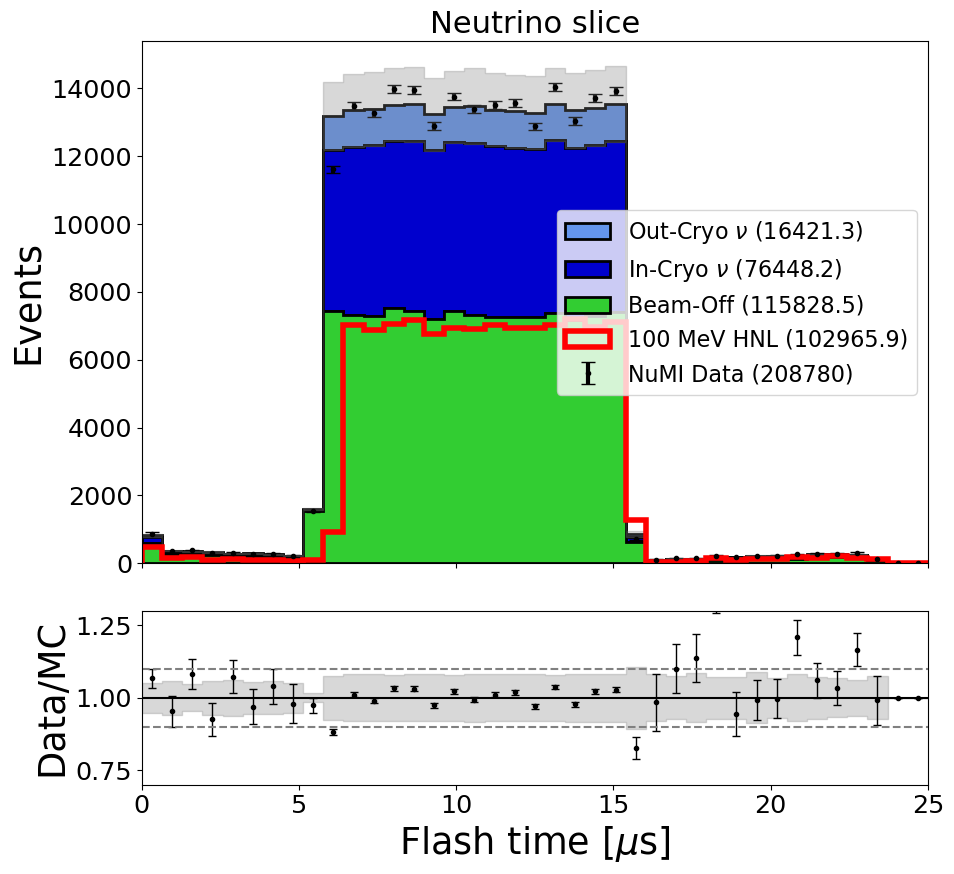

In [36]:
Plot_preselection_variable_data(variable, samples_plotting, sample_norms, query="swtrig_post>-99", xlabel=x_string, xlims=XLIMS, bins=BINS, HNL_mass=100,
                                HNLplotscale=PLOTSCALE,cutline=0.0,legloc="best", show_ev_nums=True, CalcSys=Calculate_sys,logy=False, 
                                xticks = [], sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylabel="Events", arrow_place=[], legsize=16,
                                title_name="No trigger")

Plot_preselection_variable_data(variable, samples_plotting, sample_norms, query="swtrig_pre>0", xlabel=x_string, xlims=XLIMS, bins=BINS, HNL_mass=100,
                                HNLplotscale=PLOTSCALE,cutline=0.0,legloc="best", show_ev_nums=True, CalcSys=Calculate_sys,logy=False, 
                                xticks = [], sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylabel="Events", arrow_place=[], legsize=16,
                                title_name="Old trigger")

Plot_preselection_variable_data(variable, samples_plotting, sample_norms, query="swtrig_post>0", xlabel=x_string, xlims=XLIMS, bins=BINS, HNL_mass=100,
                                HNLplotscale=PLOTSCALE,cutline=0.0,legloc="best", show_ev_nums=True, CalcSys=Calculate_sys,logy=False, 
                                xticks = [], sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylabel="Events", arrow_place=[], legsize=16,
                                title_name="New trigger")

Plot_preselection_variable_data(variable, samples_plotting, sample_norms, query='nslice==1', xlabel=x_string, xlims=XLIMS, bins=BINS, HNL_mass=100,
                                HNLplotscale=PLOTSCALE,cutline=0.0,legloc="best", show_ev_nums=True, CalcSys=Calculate_sys,logy=False, 
                                xticks = [], sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylabel="Events", arrow_place=[], legsize=16,
                                title_name="Neutrino slice")

In [ ]:
Calculate_sys = True
variable = 'nslice'

reload(PT)
reload(Functions)
reload(Constants)
reload(Sys_unc)
reload(Variables_bins)

if Params["Run"] == "run1": 
    flat_sys_vars_dict = Sys_unc.run1_Sys_unc
    PLOTSCALE = 240000000
if Params["Run"] == "run3": 
    flat_sys_vars_dict = Sys_unc.run3_Sys_unc
    PLOTSCALE = 240000000

if isinstance(Constants.variable_names_dict[variable],str):x_string = Constants.variable_names_dict[variable]
else: x_string=variable
BINS = Variables_bins.Presel_bins[variable]
XLIMS = [BINS[0],BINS[-1]]

In [ ]:
Plot_preselection_variable_data(variable, samples_plotting, sample_norms, query="swtrig_post>-99", xlabel=x_string, xlims=XLIMS, bins=BINS, HNL_mass=100,
                                HNLplotscale=PLOTSCALE,cutline=0.0,legloc="best", show_ev_nums=True, CalcSys=Calculate_sys,logy=False, 
                                xticks = [0,1], sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylabel="Events", arrow_place=[], legsize=16,
                                title_name="No trigger")

Plot_preselection_variable_data(variable, samples_plotting, sample_norms, query="swtrig_pre>0", xlabel=x_string, xlims=XLIMS, bins=BINS, HNL_mass=100,
                                HNLplotscale=PLOTSCALE,cutline=0.0,legloc="best", show_ev_nums=True, CalcSys=Calculate_sys,logy=False, 
                                xticks = [0,1], sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylabel="Events", arrow_place=[], legsize=16,
                                title_name="Old trigger")

Plot_preselection_variable_data(variable, samples_plotting, sample_norms, query="swtrig_post>0", xlabel=x_string, xlims=XLIMS, bins=BINS, HNL_mass=100,
                                HNLplotscale=PLOTSCALE,cutline=0.0,legloc="best", show_ev_nums=True, CalcSys=Calculate_sys,logy=False, 
                                xticks = [0,1], sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylabel="Events", arrow_place=[], legsize=16,
                                title_name="New trigger")

## Splitting into post and pre samples

In [58]:
samples_plotting['overlay'].keys()
root_dir = 'nuselection'

sample_loc = {"overlay":f'../NuMI_MC/SLIMMED_neutrinoselection_filt_'+Params["Run"]+'_overlay.root',
              "dirtoverlay":f'../NuMI_MC/neutrinoselection_filt_'+Params["Run"]+'_dirt_overlay.root',
              "beamoff":f'../NuMI_data/neutrinoselection_filt_'+Params["Run"]+'_beamoff.root',
              "signal":f'../NuMI_signal/KDAR_dump/sfnues/sfnues_KDAR_dump_',
              "pi0_signal":f'../NuMI_signal/KDAR_dump/sfnues/pi0/sfnues_KDAR_dump_',
              "beamgood":f'../NuMI_data/neutrinoselection_filt_'+Params["Run"]+'_beamon_beamgood.root'}

In [59]:
#Taken from Owen
beamgood, beamoff, overlay, dirtoverlay = {}, {}, {}, {}
sample_info = {"beamgood":beamgood, "beamoff":beamoff, "overlay":overlay, "dirtoverlay":dirtoverlay}
runsplit=16880
if(Params["Run"]=="run1"):
    print("nope")
else:
    sample_info["beamgood"]["POT_post"]=9.049e+19
    sample_info["beamgood"]["POT_pre"]=4.105e+20
    sample_info["beamgood"]["hwtrigs_post"]=1845342
    sample_info["beamgood"]["hwtrigs_pre"]=8519685
    sample_info["beamoff"]["hwtrigs_post"]=14382545.975000
    sample_info["beamoff"]["hwtrigs_pre"]= 18772346.425000

    # i split the MC at 16880 but this is actually somewhat arbitary (the run is just defined by the underlying unbiased event)
    # doesnt actually create a very approprieate split. #can also not split MC and just scale all together with updated threshold. (this actually gives best agreement)
    #i dont think suprising because we know simualtion vs data light yeild not great especially at low light level.
    file=uproot.open(f'../NuMI_MC/SLIMMED_neutrinoselection_filt_'+Params["Run"]+'_overlay.root')[root_dir]
    sample_info["overlay"]["POT_post"]=sum(file["SubRun"]["pot"].array()[file["SubRun"]["run"].array()>=runsplit])
    sample_info["overlay"]["POT_pre"]=sum(file["SubRun"]["pot"].array()[file["SubRun"]["run"].array()<runsplit])
    
    file=uproot.open(f'../NuMI_MC/neutrinoselection_filt_'+Params["Run"]+'_dirt_overlay.root')[root_dir]
    sample_info["dirtoverlay"]["POT_post"]=sum(file["SubRun"]["pot"].array()[file["SubRun"]["run"].array()>=runsplit])
    sample_info["dirtoverlay"]["POT_pre"]=sum(file["SubRun"]["pot"].array()[file["SubRun"]["run"].array()<runsplit])

    sample_info["dirtoverlay"]["NormScale_post"]=(sample_info["beamgood"]["POT_post"]/sample_info["dirtoverlay"]["POT_post"])*0.35
    sample_info["dirtoverlay"]["NormScale_pre"]=(sample_info["beamgood"]["POT_pre"]/sample_info["dirtoverlay"]["POT_pre"])*0.35

    sample_info["beamgood"]["NormScale"]=1

    sample_info["beamoff"]["NormScale_pre"]=(sample_info["beamgood"]["hwtrigs_pre"]/sample_info["beamoff"]["hwtrigs_pre"])*0.98
    sample_info["beamoff"]["NormScale_post"]=(sample_info["beamgood"]["hwtrigs_post"]/sample_info["beamoff"]["hwtrigs_post"])*0.98

    sample_info["overlay"]["NormScale_pre"]=(sample_info["beamgood"]["POT_pre"]/sample_info["overlay"]["POT_pre"])
    sample_info["overlay"]["NormScale_post"]=(sample_info["beamgood"]["POT_post"]/sample_info["overlay"]["POT_post"])

In [60]:
print("POTs:")
print("overlay pre: " + str(sample_info["overlay"]["POT_pre"]))
print("overlay post: " + str(sample_info["overlay"]["POT_post"]))

print("dirt pre: " + str(sample_info["dirtoverlay"]["POT_pre"]))
print("dirt post: " + str(sample_info["dirtoverlay"]["POT_post"]))
print()

print("Scalings:")
print("beamoff pre: " + str(sample_info["beamoff"]["NormScale_pre"]))
print("beamoff post: " + str(sample_info["beamoff"]["NormScale_post"]))

print("overlay pre: " + str(sample_info["overlay"]["NormScale_pre"]))
print("overlay post: " + str(sample_info["overlay"]["NormScale_post"]))

print("dirt pre: " + str(sample_info["dirtoverlay"]["NormScale_pre"]))
print("dirt post: " + str(sample_info["dirtoverlay"]["NormScale_post"]))

POTs:
overlay pre: 1.536880452623554e+21
overlay post: 4.524813975870935e+20
dirt pre: 6.014158669098967e+20
dirt post: 4.308466313048621e+20

Scalings:
beamoff pre: 0.4447654603731829
beamoff post: 0.12573818037108692
overlay pre: 0.26709949970360414
overlay post: 0.1999861220429123
dirt pre: 0.2388945950797889
dirt post: 0.07350991675176778


In [65]:
old_trig_samples = {"overlay":swtrig["overlay"].query("swtrig_pre>0"),
                    "dirtoverlay":swtrig["dirtoverlay"].query("swtrig_pre>0"),
                    "beamoff":swtrig["beamoff"].query("swtrig_pre>0"),
                    "signal":swtrig[HNL_mass].query("swtrig_pre>0")}

new_trig_samples = {"overlay":swtrig["overlay"].query("swtrig_post>0"),
                    "dirtoverlay":swtrig["dirtoverlay"].query("swtrig_post>0"),
                    "beamoff":swtrig["beamoff"].query("swtrig_post>0"),
                    "signal":swtrig[HNL_mass].query("swtrig_post>0")}

weight_Offbeam=np.ones(len(samples_plotting["beamoff"]['nslice']))*np.where(samples_plotting["beamoff"]["run"]<16880, sample_info["beamoff"]["NormScale_pre"], sample_info["beamoff"]["NormScale_post"])
weight_Overlay=samples_plotting["overlay"]["weight"]*np.where(samples_plotting["overlay"]["run"]<runsplit, sample_info["overlay"]["NormScale_pre"], sample_info["overlay"]["NormScale_post"])
weight_Dirt=samples_plotting["dirtoverlay"]["weight"]*np.where(samples_plotting["dirtoverlay"]["run"]<runsplit, sample_info["dirtoverlay"]["NormScale_pre"], sample_info["dirtoverlay"]["NormScale_post"])

weight_signal=np.ones(len(samples_plotting["signal"]["nslice"]))*sample_norms["signal"]*PLOTSCALE
    
weights_sample_fixed = {'overlay':weight_Overlay,
                      'dirtoverlay':weight_Dirt,
                      'beamoff':weight_Offbeam,
                      'signal':weight_signal}

weight_Offbeam=np.ones(len(old_trig_samples["beamoff"]['nslice']))*np.where(old_trig_samples["beamoff"]["run"]<16880, sample_info["beamoff"]["NormScale_pre"], sample_info["beamoff"]["NormScale_post"])
weight_Overlay=old_trig_samples["overlay"]["weight"]*np.where(old_trig_samples["overlay"]["run"]<runsplit, sample_info["overlay"]["NormScale_pre"], sample_info["overlay"]["NormScale_post"])
weight_Dirt=old_trig_samples["dirtoverlay"]["weight"]*np.where(old_trig_samples["dirtoverlay"]["run"]<runsplit, sample_info["dirtoverlay"]["NormScale_pre"], sample_info["dirtoverlay"]["NormScale_post"])

weight_signal=np.ones(len(old_trig_samples["signal"]["nslice"]))*sample_norms["signal"]*PLOTSCALE
    
weights_sample_old_trig = {'overlay':weight_Overlay,
                      'dirtoverlay':weight_Dirt,
                      'beamoff':weight_Offbeam,
                      'signal':weight_signal}

weight_Offbeam=np.ones(len(new_trig_samples["beamoff"]['nslice']))*np.where(new_trig_samples["beamoff"]["run"]<16880, sample_info["beamoff"]["NormScale_pre"], sample_info["beamoff"]["NormScale_post"])
weight_Overlay=new_trig_samples["overlay"]["weight"]*np.where(new_trig_samples["overlay"]["run"]<runsplit, sample_info["overlay"]["NormScale_pre"], sample_info["overlay"]["NormScale_post"])
weight_Dirt=new_trig_samples["dirtoverlay"]["weight"]*np.where(new_trig_samples["dirtoverlay"]["run"]<runsplit, sample_info["dirtoverlay"]["NormScale_pre"], sample_info["dirtoverlay"]["NormScale_post"])

weight_signal=np.ones(len(new_trig_samples["signal"]["nslice"]))*sample_norms["signal"]*PLOTSCALE
    
weights_sample_new_trig = {'overlay':weight_Overlay,
                      'dirtoverlay':weight_Dirt,
                      'beamoff':weight_Offbeam,
                      'signal':weight_signal}

In [78]:
Calculate_sys = True
variable = 'flash_time'

reload(PT)
reload(Functions)
reload(Constants)
reload(Sys_unc)
reload(Variables_bins)

if Params["Run"] == "run1": 
    flat_sys_vars_dict = Sys_unc.run1_Sys_unc
    PLOTSCALE = 240000000
if Params["Run"] == "run3": 
    flat_sys_vars_dict = Sys_unc.run3_Sys_unc
    PLOTSCALE = 240000000

if isinstance(Constants.variable_names_dict[variable],str):x_string = Constants.variable_names_dict[variable]
else: x_string=variable
BINS = Variables_bins.Presel_bins[variable]
XLIMS = [BINS[0],BINS[-1]]

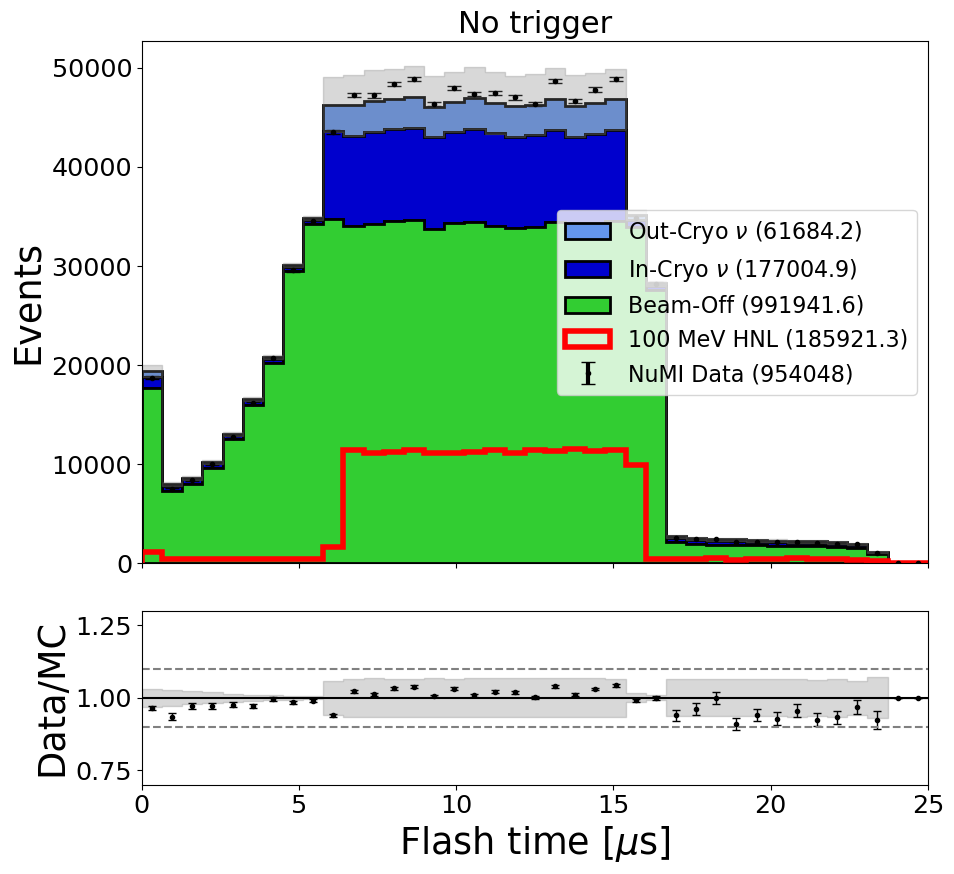

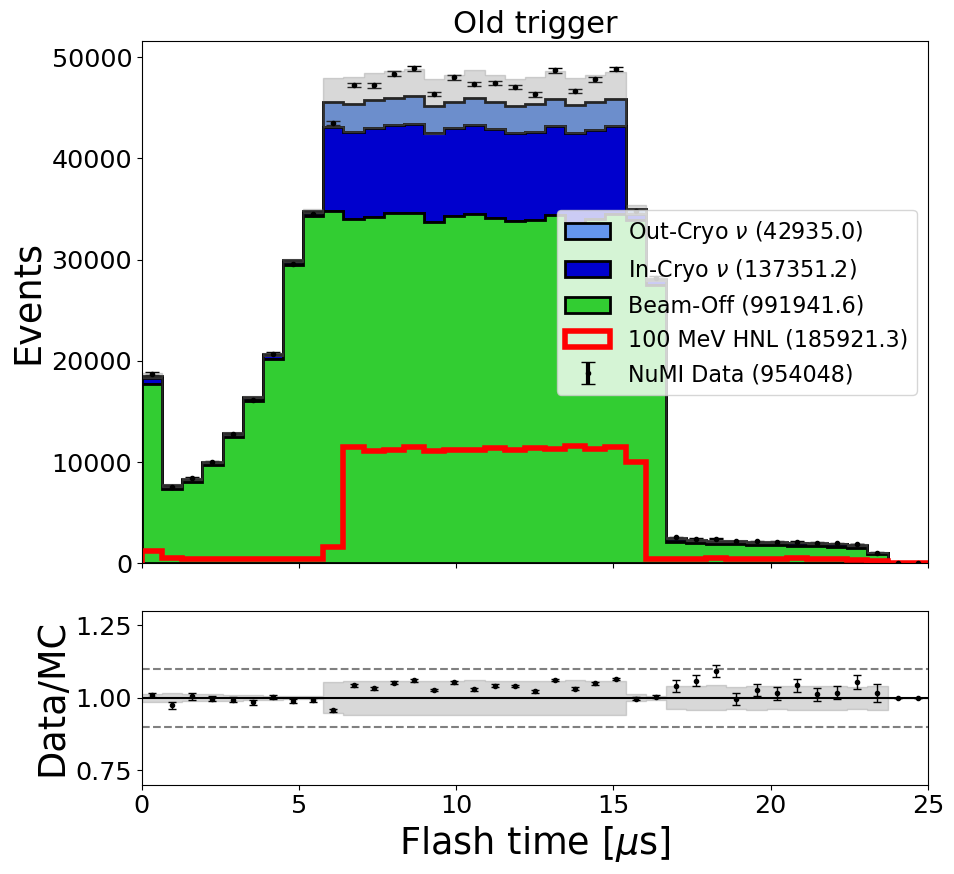

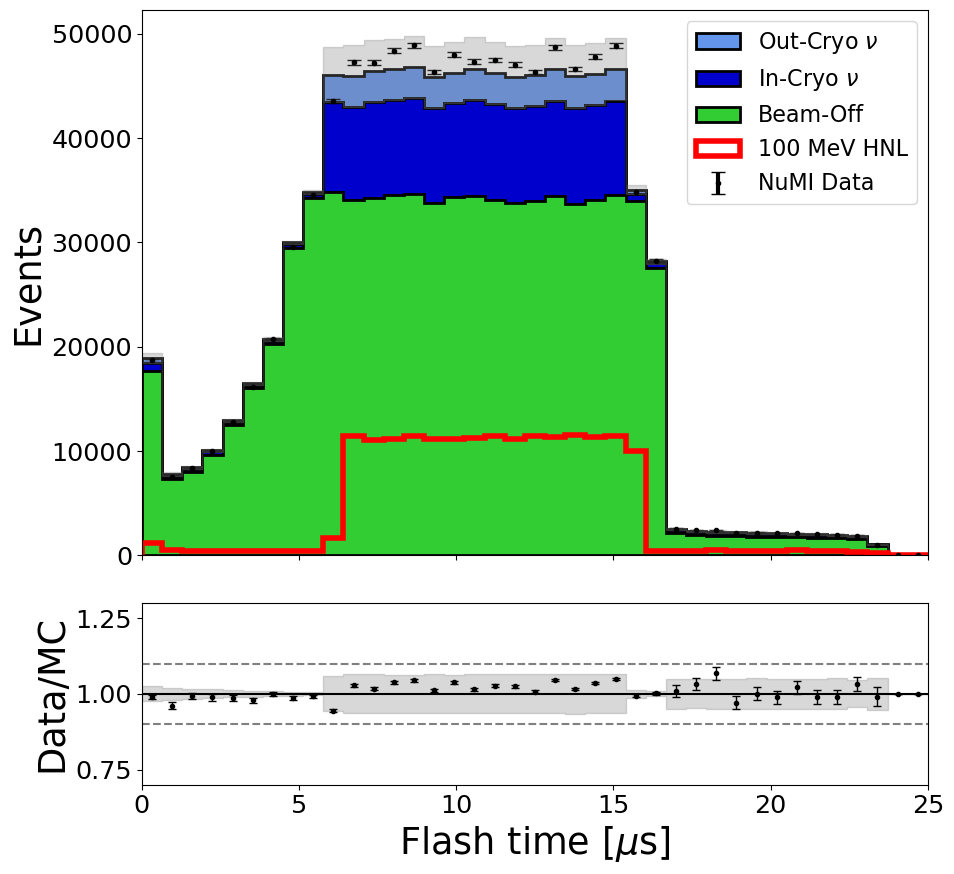

In [79]:
Plot_preselection_variable_data(variable, samples_plotting, sample_norms,sample_weights_full=weights_sample_fixed, query="swtrig_post>-99", xlabel=x_string, xlims=XLIMS, bins=BINS, HNL_mass=100,
                                HNLplotscale=PLOTSCALE,cutline=0.0,legloc="best", show_ev_nums=True, CalcSys=Calculate_sys,logy=False, 
                                xticks = [], sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylabel="Events", arrow_place=[], legsize=16,
                                title_name="No trigger")

Plot_preselection_variable_data(variable, samples_plotting, sample_norms,sample_weights_full=weights_sample_old_trig, query="swtrig_pre>0", xlabel=x_string, xlims=XLIMS, bins=BINS, HNL_mass=100,
                                HNLplotscale=PLOTSCALE,cutline=0.0,legloc="best", show_ev_nums=True, CalcSys=Calculate_sys,logy=False, 
                                xticks = [], sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylabel="Events", arrow_place=[], legsize=16,
                                title_name="Old trigger")

Plot_preselection_variable_data(variable, samples_plotting, sample_norms,sample_weights_full=weights_sample_new_trig, query="swtrig_post>0", xlabel=x_string, xlims=XLIMS, bins=BINS, HNL_mass=100,
                                HNLplotscale=PLOTSCALE,cutline=0.0,legloc="best", show_ev_nums=False, CalcSys=Calculate_sys,logy=False, 
                                xticks = [], sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylabel="Events", arrow_place=[], legsize=16,
                                title_name="")

savefig=True

Name = "Split_swtrig_"
if Params["Load_pi0_signal"] == True: Name = "pi0/"
if Calculate_sys==True: Sys_name = "with_sys"
if Calculate_sys==False: Sys_name = "no_sys"

if savefig == True:
    plt.savefig(f"plots/Data_MC_comparison/{Name}Presel_{variable}_" + Params["Run"] + f"_{HNL_mass}MeV_{Sys_name}.png")
    plt.savefig(f"plots/Data_MC_comparison/{Name}Presel_{variable}_" + Params["Run"] + f"_{HNL_mass}MeV_{Sys_name}.pdf")


In [80]:
Calculate_sys = True
variable = 'nslice'

reload(PT)
reload(Functions)
reload(Constants)
reload(Sys_unc)
reload(Variables_bins)

if Params["Run"] == "run1": 
    flat_sys_vars_dict = Sys_unc.run1_Sys_unc
    PLOTSCALE = 240000000
if Params["Run"] == "run3": 
    flat_sys_vars_dict = Sys_unc.run3_Sys_unc
    PLOTSCALE = 240000000

if isinstance(Constants.variable_names_dict[variable],str):x_string = Constants.variable_names_dict[variable]
else: x_string=variable
BINS = Variables_bins.Presel_bins[variable]
XLIMS = [BINS[0],BINS[-1]]

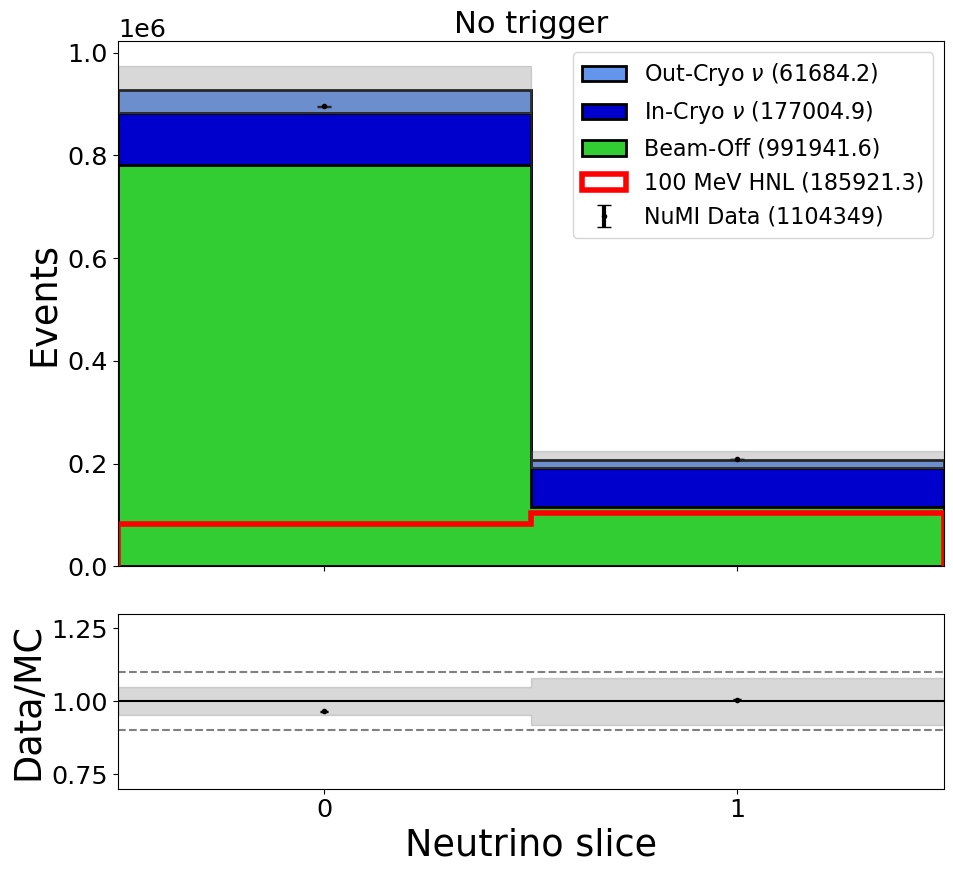

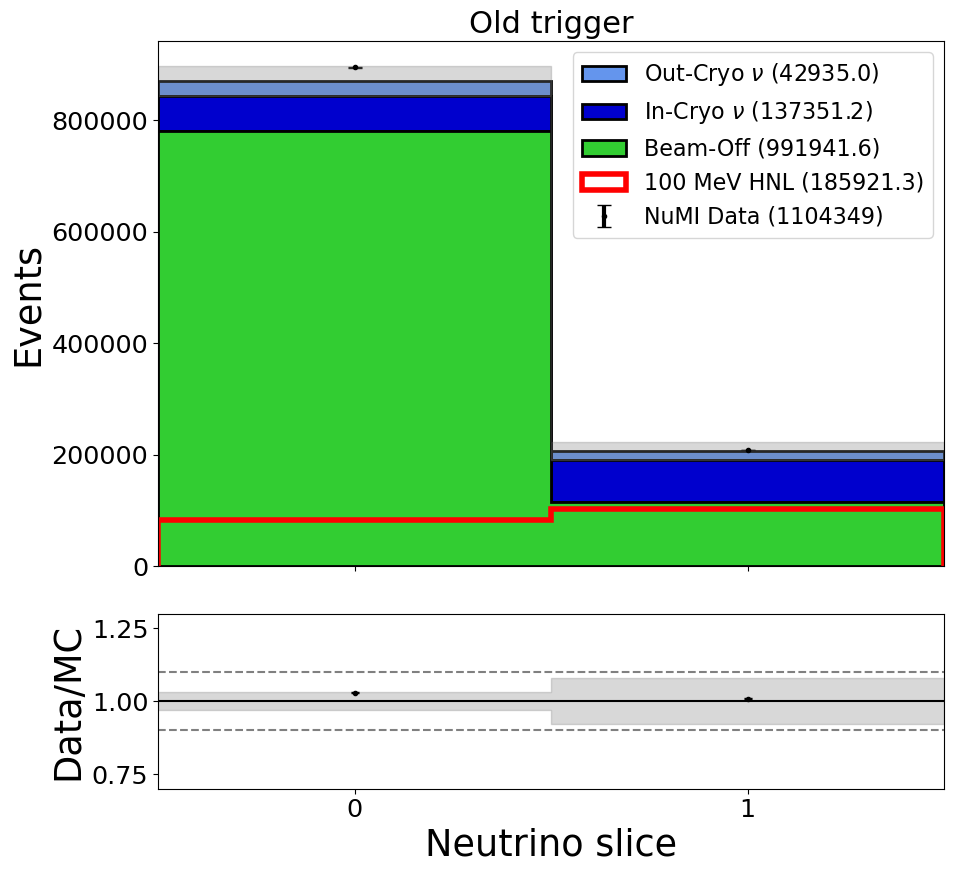

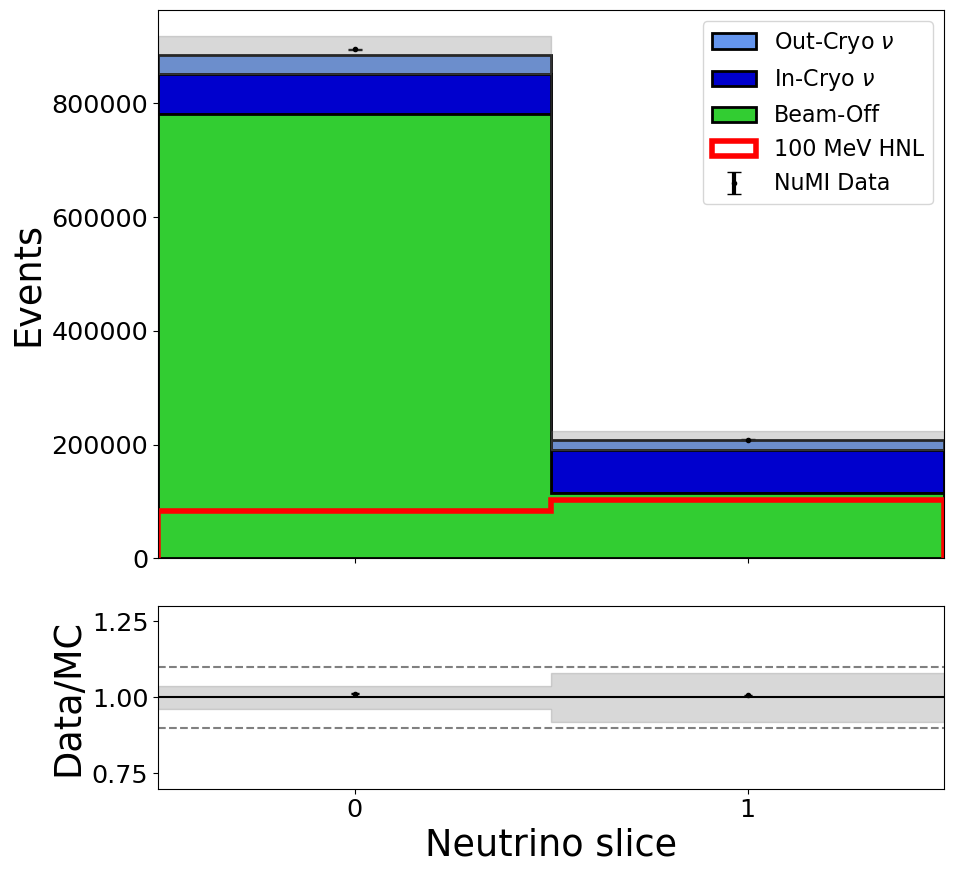

In [81]:
Plot_preselection_variable_data(variable, samples_plotting, sample_norms,sample_weights_full=weights_sample_fixed, query="swtrig_post>-99", xlabel=x_string, xlims=XLIMS, bins=BINS, HNL_mass=100,
                                HNLplotscale=PLOTSCALE,cutline=0.0,legloc="best", show_ev_nums=True, CalcSys=Calculate_sys,logy=False, 
                                xticks = [0,1], sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylabel="Events", arrow_place=[], legsize=16,
                                title_name="No trigger")

Plot_preselection_variable_data(variable, samples_plotting, sample_norms,sample_weights_full=weights_sample_old_trig, query="swtrig_pre>0", xlabel=x_string, xlims=XLIMS, bins=BINS, HNL_mass=100,
                                HNLplotscale=PLOTSCALE,cutline=0.0,legloc="best", show_ev_nums=True, CalcSys=Calculate_sys,logy=False, 
                                xticks = [0,1], sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylabel="Events", arrow_place=[], legsize=16,
                                title_name="Old trigger")

Plot_preselection_variable_data(variable, samples_plotting, sample_norms,sample_weights_full=weights_sample_new_trig, query="swtrig_post>0", xlabel=x_string, xlims=XLIMS, bins=BINS, HNL_mass=100,
                                HNLplotscale=PLOTSCALE,cutline=0.0,legloc="best", show_ev_nums=False, CalcSys=Calculate_sys,logy=False, 
                                xticks = [0,1], sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylabel="Events", arrow_place=[], legsize=16,
                                title_name="")

Name = "Split_swtrig_"
if Params["Load_pi0_signal"] == True: Name = "pi0/"
if Calculate_sys==True: Sys_name = "with_sys"
if Calculate_sys==False: Sys_name = "no_sys"

if savefig == True:
    plt.savefig(f"plots/Data_MC_comparison/{Name}Presel_{variable}_" + Params["Run"] + f"_{HNL_mass}MeV_{Sys_name}.png")
    plt.savefig(f"plots/Data_MC_comparison/{Name}Presel_{variable}_" + Params["Run"] + f"_{HNL_mass}MeV_{Sys_name}.pdf")


## Plotting only highest E object

In [ ]:
Highest_E_placeholder = Functions.only_keep_highest_E(samples_dict[HNL_mass])

samples_plotting = {"overlay":samples_dict["overlay"],
           "dirtoverlay":samples_dict["dirtoverlay"],
           "beamoff":samples_dict["beamoff"],
           "signal":Highest_E_placeholder}

PT.Plot_preselection_variable(variable, samples_plotting, sample_norms, xlabel=[],xlims=[1,100],bins=100, HNL_mass=HNL_mass,
                              HNLplotscale=600000,cutline=0.0,legloc="upper right")

plt.savefig("plots/Preselection_variables/" + Params["Run"] + "_" + str(HNL_mass) + "_MeV_" + str(variable)+"_highest_E.png")

## Plot only signal samples before preselection

In [ ]:
#Need a new plotting function for this
reload(Constants)

# Pre-selection cuts

In [ ]:
def count_unique_events(df):
    placeholder=df.drop_duplicates(subset=["run","evt","sub"]).copy()
    unique_evs = len(placeholder)
    del placeholder
    return unique_evs

def make_unique_events_df(df):
    placeholder=df.drop_duplicates(subset=["run","evt","sub"]).copy()
    return placeholder

def Preselection_weighted_efficiency(samples, cut_dict, Efficiency_dict, Preselected): #Need to account for weigthing in overlay and dirt samples
    for sample in samples:
        if sample == "overlay" or sample == "dirtoverlay" or sample in Constants.Detector_variations:
            weight = samples[sample]["weight"]
            NumEvs = sum(weight)
        else:
            NumEvs = len(samples[sample])
        
        effic_list = [1.0]
        for cut in cut_dict.keys():
            samples[sample]=samples[sample].query(cut_dict[cut])
            if sample == "overlay" or sample == "dirtoverlay" or sample in Constants.Detector_variations:
                weight = samples[sample]["weight"]
                Num_selected = sum(weight)
            else:
                Num_selected = len(samples[sample])
            effic_list.append(Num_selected/NumEvs)
        Efficiency_dict[sample]=effic_list
        #samples.update()
        Selected = samples[sample].copy()
        placeholder_dict = {sample:Selected}
        Preselected.update(placeholder_dict) 
        
def Flattened_Preselection_weighted_efficiency(samples, cut_dict, Efficiency_dict, Preselected, Run): #Need to account for weigthing in overlay and dirt samples
    for sample in samples:
        if sample == "overlay" or sample == "dirtoverlay" or sample in Constants.Detector_variations:
            # unique_placeholder = make_unique_events_df(samples[sample])
            # weight = unique_placeholder["weight"]
            # NumEvs = sum(weight)
            if Run == "run1":NumEvs = Constants.run1_sum_weights[sample] #This is the total BEFORE any preselection
            if Run == "run3":NumEvs = Constants.run3_sum_weights[sample]
        else:
            if Run == "run1":NumEvs = Constants.run1_event_numbers[sample]
            if Run == "run3":NumEvs = Constants.run3_event_numbers[sample]
        
        effic_list = [1.0]
        for cut in cut_dict.keys():
            samples[sample]=samples[sample].query(cut_dict[cut])
            if sample == "overlay" or sample == "dirtoverlay" or sample in Constants.Detector_variations:
                unique_placeholder = make_unique_events_df(samples[sample])
                weight = unique_placeholder["weight"]
                Num_selected = sum(weight)
            else:
                unique_placeholder = make_unique_events_df(samples[sample])
                Num_selected = len(unique_placeholder)
            effic_list.append(Num_selected/NumEvs)
        Efficiency_dict[sample]=effic_list
        #samples.update()
        Selected = samples[sample].copy()
        placeholder_dict = {sample:Selected}
        Preselected.update(placeholder_dict) 
    
def Preselection_DetVars(samples, cut_dict, Preselected): #Not making efficiency plots for DetVars
    for sample in samples:
        for cut in cut_dict.keys():
            samples[sample]=samples[sample].query(cut_dict[cut])
        Selected = samples[sample].copy()
        placeholder_dict = {sample:Selected}
        Preselected.update(placeholder_dict)

In [ ]:
#Make cuts on signal
if Params["Run"] == "run1": 
    if Params["Load_pi0_signal"] == False:
        if Params["FLATTEN"] == True:
            Preselection_dict = Constants.Preselection_dict 
        else:
            Preselection_dict = Constants.Preselection_dict_for_plot
    if Params["Load_pi0_signal"] == True:
        Preselection_dict = Constants.Preselection_dict_for_plot
        # Preselection_dict = Constants.Preselection_dict_pi0
        
elif Params["Run"] == "run3":
    if Params["Load_pi0_signal"] == False:
        if Params["FLATTEN"] == True:
            Preselection_dict = Constants.Preselection_dict
        else:
            Preselection_dict = Constants.Preselection_dict_for_plot
    if Params["Load_pi0_signal"] == True:
        # Preselection_dict = Constants.Preselection_dict_pi0
        Preselection_dict = Constants.Preselection_dict_for_plot
    Preselection_dict.update(Constants.Preselection_dict_crtveto) #Adding crtveto cut
        
if (Params["Load_DetVars"] == True) and (Params["Run"] == "run3"):
    removed=Preselection_dict.pop('Fiducial_cut')        

print("Preselection is:" + "\n")
print(Preselection_dict)
print()


In [ ]:
# if (Params["Load_DetVars"] == True) and (Params["Run"] == "run3"):
#     removed=Preselection_dict.pop('Fiducial_cut')
    
# print(Preselection_dict)

In [ ]:
sample_dict_copy = {}
for sample in samples_dict:
    sample_dict_copy[sample] = swtrig[sample].copy()

Efficiency_dict = {}
Preselected_dict = {}
if (Params["Load_DetVars"] == True) or (Params["Load_Signal_DetVars"] == True) or (Params['Load_pi0_signal_DetVars'] == True):
    Preselection_DetVars(sample_dict_copy, Preselection_dict, Preselected_dict)
else:
    if Params["FLATTEN"] == False:
        Preselection_weighted_efficiency(sample_dict_copy, Preselection_dict, Efficiency_dict, Preselected_dict)
    if Params["FLATTEN"] == True:
        Flattened_Preselection_weighted_efficiency(sample_dict_copy, Preselection_dict, Efficiency_dict, Preselected_dict, Params["Run"])

In [ ]:
print(sample_dict_copy.keys())
reload(Constants)

In [ ]:
#Working out the maximum and minimum efficiencies for signal "band"
Preselection_signal_max = []
Preselection_signal_min = []

max_presel_effic = 0.0 #Placeholder to record the highest efficiency
min_presel_effic = 1.0 #Placeholder to record the lowest efficiency

if Params["Load_pi0_signal"] == False: HNL_masses = Constants.HNL_mass_samples
if Params["Load_pi0_signal"] == True: HNL_masses = Constants.HNL_mass_pi0_samples_names
if (Params["Load_pi0_signal"] == True) and (Params["Load_lepton_signal"] == True): 
    HNL_masses = Constants.HNL_mass_samples+Constants.HNL_mass_pi0_samples_names

for i in range(len(Preselection_dict)+1):
    for HNL_mass in HNL_masses: 
        if Efficiency_dict[HNL_mass][i] > max_presel_effic:
            max_presel_effic = Efficiency_dict[HNL_mass][i]
        if Efficiency_dict[HNL_mass][i] < min_presel_effic:
            min_presel_effic = Efficiency_dict[HNL_mass][i]
    Preselection_signal_max.append(max_presel_effic)
    Preselection_signal_min.append(min_presel_effic)
    max_presel_effic = 0.0

In [ ]:
print(Preselection_signal_max)
print(Preselection_signal_min)

In [ ]:
print(Preselected_dict.keys())

In [ ]:
print(Efficiency_dict[50])
print(Efficiency_dict['245_pi0'])

## Only select highest energy object and "Prepare" for xgboost

In [ ]:
def Prepare_dfs_for_xgb(df): #The default value for missing data in XGB is 0. So this changes those very large negative values to -9999.
    value = -1e15
    new_value = -9999
    first_entry = df.index[0]
    for variable in df.keys():
        if isinstance(df[variable][first_entry], (int,float,np.int32,np.float32,np.uint32)):
        # if variable=='rse_id': #Should come up with a better way of checking the "type" of variable, in case it is not int or float.
        #     continue           #But don't know how to access the first extant row of a dataframe (since some have been removed). 
        # else: 
            if(len(df.loc[df[variable] < value]) > 0):
                df.loc[(df[variable] < value), variable] = new_value #Sets the new value
            if(len(df.loc[df[variable] == -1.0]) > 0):
                df.loc[(df[variable] == -1.0), variable] = new_value #Sets the new value
            if(len(df.loc[df[variable] == np.nan]) > 0):
                df.loc[(df[variable] == np.nan), variable] = new_value #Sets the new value
            if(len(df.loc[df[variable] == np.inf]) > 0):
                df.loc[(df[variable] == np.inf), variable] = new_value #Sets the new value
        # else:
        #     print(variable)
            
    df_edited = df.copy() 
    return df_edited

def Sophisticated_dfs_for_xgb(df): #Requires a minimum of 2 reconstructed objects
    #Take highest E object
    print("Write this")
    variable = 'pfnplanehits_Y'
    # df.loc
    #Look at 2nd highest E object, if within x cm save these two
    #If not look for next highest E object and repeat. 
    #If exhausted of objects, remove event
    
    #Make event-wise variables to feed into BDT
    #Save opening angle
    #Save theta, phi of highest E object
    #Save theta, phi of lower E object
    #Save length of highest E object
    #Save length of lower E object
    #Save invariant mass of 2 objects
    #Save total E of both objects

In [ ]:
Prepared_dict = {}
for sample in Preselected_dict:
    Highest_E_placeholder = Functions.only_keep_highest_E(Preselected_dict[sample])
    Prepared_dict[sample] = Functions.Prepare_dfs_for_xgb(Highest_E_placeholder)
print(Prepared_dict.keys())

# Save pkls

In [ ]:
print_vals = input("Do you want to save the pickle files? y/n ")
if print_vals == "y":
    loc_pkls = "pkl_files/"+Params["Run"]+"/current_files/"+Params["variables_string"]+"/"
    
    for sample in Preselected_dict:
        print("Saving "+Params["Run"]+f" Preselected {sample} .pkl")
        if sample in Constants.Detector_variations:
            #Preselected_dict[sample].to_pickle(loc_pkls+"DetVars/"+"Preselected_overlay_"+Params["Run"]+"_"+Params["variables_string"]+f"_{sample}_"+Params["Flat_state"]+"_"+Params["Reduced_state"]+".pkl")
            Prepared_dict[sample].to_pickle(loc_pkls+"DetVars/"+"Preselected_overlay_"+Params["Run"]+"_"+Params["variables_string"]+
                                            f"_{sample}_"+Params["Flat_state"]+"_"+Params["Reduced_state"]+"_FINAL.pkl")
        if Params["Load_Signal_DetVars"] == True:
            Prepared_dict[sample].to_pickle(loc_pkls+"Signal_DetVars/"+"Preselected_"+Params["Run"]+
                                            f"_{sample}_"+Params["Reduced_state"]+"_FINAL.pkl")
        
        if Params["Load_pi0_signal"] == True:
            Prepared_dict[sample].to_pickle(loc_pkls+"pi0_selection/Preselected_"+Params["Run"]+
                                            f"_{sample}"+"_FINAL.pkl")
        
        else:
            #Preselected_dict[sample].to_pickle(loc_pkls+f"Preselected_{sample}_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+".pkl")
            Prepared_dict[sample].to_pickle(loc_pkls+f"Preselected_{sample}_"+Params["Run"]+"_"+
                                            Params["variables_string"]+"_"+Params["Flat_state"]+"_FINAL.pkl")

else:
    print("Not saving pickle files, move onto next cell")

# Plotting Efficiencies

In [ ]:
reload(Constants)

var_names = []
for var in Preselection_dict.keys():
    # var_names.append(Constants.variable_names_dict[var])
    var_names.append(Constants.presel_var_names[var])
print(var_names)


In [ ]:
#Signal-only efficiencies
plt.figure(figsize=[10,10])


plotting_effic_dict = {'overlay':Efficiency_dict['overlay'], 'dirtoverlay':Efficiency_dict['dirtoverlay'],
                      'beamoff':Efficiency_dict['beamoff']}
label_effic_dict = {'overlay':fr"In-Cryo $\nu$", 'dirtoverlay':fr"Out-Cryo $\nu$",
                      'beamoff':f"Beam-Off"}

plotting_effic_colours = Constants.sample_colours

log = True

if log == True:
    logscale="log"
elif log == False:
    logscale="linear"

for effic in plotting_effic_dict:
    plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Efficiency_dict[effic],label=label_effic_dict[effic],color=plotting_effic_colours[effic],lw=4,markersize=15)

plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Preselection_signal_max,color="darkred",lw=4,marker="")
plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Preselection_signal_min,color="darkred",lw=4,marker="")
plt.fill_between(np.array(range(1, len(Efficiency_dict[effic])+1)),Preselection_signal_min,Preselection_signal_max,label="HNL (Range)",color="red")
plt.ylabel("Fraction Selected")
plt.xticks(np.array(range(1, len(Efficiency_dict['overlay'])+1)),["Full sample"]+var_names,rotation=80)
plt.yscale(logscale)
plt.legend(loc='lower left',prop={'size': 22})

plt.tight_layout()

save_fig = input("Do you want to save the figure? y/n ")
if Params["FLATTEN"] == False: weighted_name = "_non_weighted_FINAL"
if Params["FLATTEN"] == True: weighted_name = "_weighted_BOTH_FINAL"
if save_fig == 'y':
    plt.savefig("plots/Preselection_efficiencies/Preselection_efficiency_"+Params["Run"]+ "_" + logscale + f"{weighted_name}.png")
    plt.savefig("plots/Preselection_efficiencies/Preselection_efficiency_"+Params["Run"]+ "_" + logscale + f"{weighted_name}.pdf")

In [ ]:
print(Preselection_dict.keys())

## Plotting single mass point and background

In [ ]:
#Plotting efficiency
signal_mass = 220
plt.figure(figsize=[10,10])
plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Efficiency_dict[signal_mass],label=f"{signal_mass} MeV HNL",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Efficiency_dict['overlay'],label="MC run1 overlay",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Efficiency_dict['dirtoverlay'],label="MC run1 dirt",lw=4,markersize=15)
plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Efficiency_dict['beamoff'],label="MC run1 EXT",lw=4,markersize=15)
plt.ylabel("Fraction Selected")
plt.xticks(np.array(range(1, len(Efficiency_dict[effic])+1)),["Full sample"]+list(Preselection_dict.keys()),rotation=80)
#plt.yscale("log")
plt.legend()


## Plotting just signal

In [ ]:
plt.figure(figsize=[10,10])

for HNL_mass in Constants.HNL_mass_samples:
    plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Efficiency_dict[HNL_mass],label=f"{HNL_mass} MeV HNL",lw=4,markersize=15)
    
plt.ylabel("Fraction Selected")
plt.xticks(np.array(range(1, len(Efficiency_dict[effic])+1)),["Full sample"]+list(Preselection_dict.keys()),rotation=80)
# plt.yscale("log")
plt.legend()

plt.savefig("plots/Preselection_efficiencies/Signal_only_"+Params["Run"]+"_"+Params["Flat_state"]+".png")

# Testing code

## Making sum of weights (only for unflattened)

In [ ]:
def Sum_weights(df):
    weight = df["weight"] #Just one value per event
    sum_weights = sum(weight)
    return sum_weights

for sample in ['overlay', 'dirtoverlay']:
    sum_weights_placeholder = Sum_weights(samples_dict[sample])
    print(f"{sample} sum weights is " + str(sum_weights_placeholder))

In [ ]:
#Testing what the variables look like
variable = "dvtx_x_boundary"
def test_variables(df):
    test_signal = df[variable]
    print(type(test_signal))
    print(len(test_signal))
test_variables(df_overlay_run1)
test_variables(df_dirt_run1)
test_variables(df_EXT_run1)
test_variables(df_signal_run1)

In [ ]:
#print(overlay_from_pkl['nslice'])
#print("Flat Overlay .pkl is "+str(len(FLAT_overlay_from_pkl))+" entries long.")

print("-----Unflattened-----")
unique_var = overlay_from_pkl["nslice"].unique()
print(unique_var)
unique_var = overlay_from_pkl["n_pfps"].unique()
print(unique_var)
print(overlay_from_pkl["n_pfps"])
print(type(overlay_from_pkl["n_pfps"][0]))

# for var in overlay_from_pkl.keys():
#     if type(overlay_from_pkl[var][1]) == "numpy.ndarray":
#         print(var)

# print("-----Flattened-----")
# unique_var = FLAT_overlay_from_pkl["nslice"].unique()
# print(unique_var)
# unique_var = FLAT_overlay_from_pkl["n_pfps"].unique()
# print(unique_var)
# print(FLAT_overlay_from_pkl["n_pfps"])
# print(type(FLAT_overlay_from_pkl["n_pfps"]))